jupyter notebook上での細かいテクニック等

---
### notebook上でのグラフの表示

マジックコマンドの%matplotlib inlineでノートブック内に画像として表示できる  
通常の別ウインドウでの表示と同じように操作するためには、matplotlib notebookが使える  
  
source : [jupyter notebookで触れるプロットを描く | やったことの説明](http://ksknw.hatenablog.com/entry/2016/08/04/233103)  

<IPython.core.display.Javascript object>


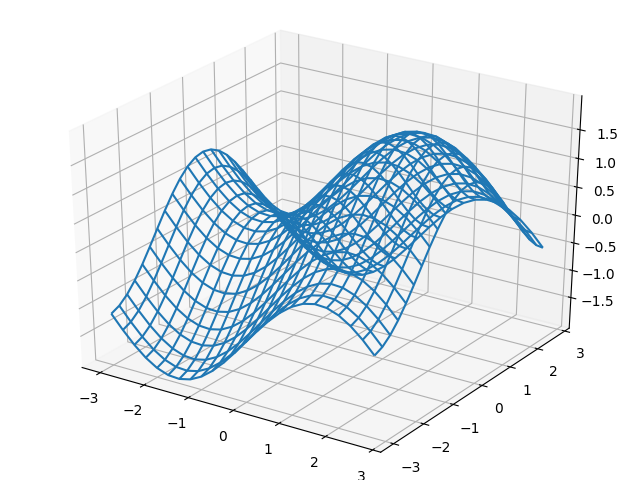

In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-3, 3, 0.25)
y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(x, y)
Z = np.sin(X)+ np.cos(Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z)

plt.show()

---
### matplotlibで２曲線の間を塗る
matplotlibの　fill_between(x, f(x), g(x))　でf(x)とg(x)の間を塗ってくれる

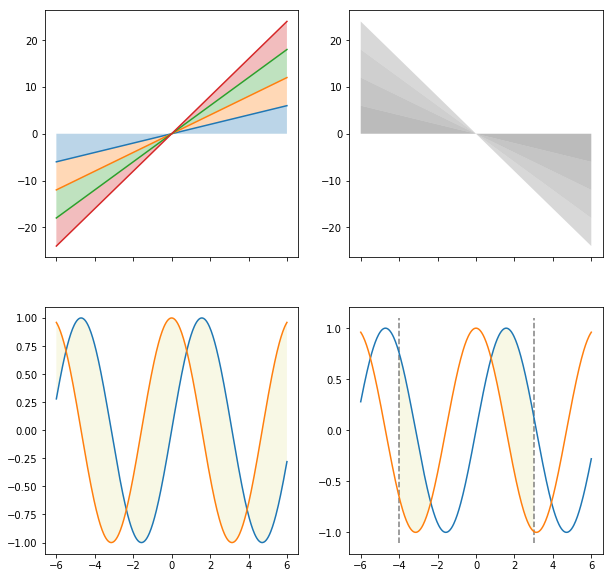

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, figsize=(10,10))

x = np.linspace(-6,6,400)

for i in [1,2,3,4]:
    ax1.plot(x,i*x)
    ax1.fill_between(x, (i-1)*x, i*x, alpha=0.3)
    
    #ax2.plot(x, -i*x, color='k')
    ax2.fill_between(x, -(i-1)*x, -i*x, facecolor='#'+str(i*20)*3, alpha=0.3)

ax3.plot(x, np.sin(x))
ax3.plot(x, np.cos(x))
ax3.fill_between(x, np.sin(x), np.cos(x), facecolor='y', alpha=0.1)

x4 = np.linspace(-4,3,400)
ax4.plot(x, np.sin(x))
ax4.plot(x, np.cos(x))
ax4.fill_between(x4, np.sin(x4), np.cos(x4), 
                 where=np.sin(x4)>np.cos(x4), facecolor='y', alpha=0.1)
ax4.vlines([-4,3], -1.1, 1.1, linestyles='dashed', alpha=0.5)

plt.show()


---
### データ構造としてのグラフをnotebook上に表示する

#### graphvizの場合  
　webにいろいろあるので略記  
　・rank, subgraph, 見えないノードを活用すれば大体期待した配置にできる  
　・texは使えないがunicodeは書ける  
　・edgeやrankの記述で初登場したnodeは、名前と表示を同じものとして自動で生成される  
　　　（よって名前と表示が同じで良いならばc.node()のような記載を省略できる）  

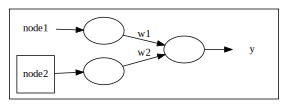

In [9]:
from graphviz import Digraph

dot = Digraph()
dot.graph_attr['rankdir']='LR'
dot.graph_attr['size']="4,4"

with dot.subgraph(name='cluster_0') as c:
    c.node('node1', 'node1', shape='plaintext')
    c.node('node2', 'node2', shape='square')
    c.node('l1a', '')
    c.node('l1b', '')
    c.edge('node1', 'l1a')
    c.edge('node2', 'l1b')
    c.node('l2', '')
    c.edge('l1a','l2', label='w1')
    c.edge('l1b', 'l2', label='w2')
    c.node('y', 'y',shape='plaintext')
    c.edge('l2','y')
    c.body.append('{rank=min; node1; node2;}')
    c.body.append('{rank=max; y;}')

dot

---
### neo4jのインストール
  
インストールはこのあたりを参照  
[neo4j operation manual : 2.2.1. Debian](https://neo4j.com/docs/operations-manual/current/installation/linux/debian/)  
[Neo4j Debian Packages](http://debian.neo4j.org/?_ga=2.31173823.1021697461.1510618935-1951245861.1510618935)  
  
起動と停止  
  
~~~
$ sudo service neo4j start
$ sudo service neo4j stop
~~~
ブラウザからアクセスできる
  
~~~
http://localhost:7474/browser/
~~~

とりあえず全てのノード、リレーションを確認するなら、ブラウザ上から  

~~~
match (n)-[r]-() return n,r
~~~

#### 公式driverの場合

~~~
pip install neo4j-driver
~~~

・データベースなので使用前に認証が必要である。方法は複数あり、以下は一例

In [ ]:
# please write your username and password when running
from neo4j.v1 import GraphDatabase

uri = 'host of your neo4j' # for example, 'bolt://localhost:7687'
driver = GraphDatabase.driver(uri, auth=("username", "your password"))

ノード及びエッジの追加と取得

In [75]:
from neo4j.v1 import GraphDatabase

sess = driver.session()
with sess.begin_transaction() as tx:
    tx.run("CREATE (alice:Person {name:'Alice'})")
    tx.run("MATCH (alice:Person) CREATE (alice)-[:Knows]->(bob:Person {name:'Bob'})") # MATCH文を外すと別ノードが作成される
    
    nodelabel, relationlabel = [], []
    for res in tx.run("MATCH (n)-[r]-() RETURN n"):
        nodelabel.append(res)
    for res in tx.run("MATCH (n)-[r]-() RETURN r"):
        relationlabel.append(res)

print("node label, ", nodelabel)
print("relation label, ", relationlabel)

node label,  [<Record n=<Node id=65 labels={'Person'} properties={'name': 'Alice'}>>, <Record n=<Node id=66 labels={'Person'} properties={'name': 'Bob'}>>]
relation label,  [<Record r=<Relationship id=63 start=65 end=66 type='Knows' properties={}>>, <Record r=<Relationship id=63 start=65 end=66 type='Knows' properties={}>>]


・各属性の取得の例

In [133]:
print(type(nodelabel))
print(type(nodelabel[0]))

nodelabel[0]

<class 'list'>
<class 'neo4j.v1.types.Record'>


<Record n=<Node id=65 labels={'Person'} properties={'name': 'Alice'}>>

In [135]:
print(type(nodelabel[0].values()))
print(type(nodelabel[0].values()[0]))

nodelabel[0].values()[0].properties['name']

<class 'tuple'>
<class 'neo4j.v1.types.Node'>


'Alice'

・特定の属性だけを取り出す

In [138]:
with sess.begin_transaction() as tx:
    node_name = []
    for res in tx.run("MATCH (n)-[r]-() RETURN n.name"):
        node_name.append(res)

print(node_name[0].values()[0])

Alice


#### Graphvizで図示する
参考：  
　[(2017.6.9) Neo4jの可視化ライブラリまとめ](https://www.slideshare.net/mkiuchi4/201769-neo4j)  
　[m-kiuchi/neo4j-vizsample/graphviz/](https://github.com/m-kiuchi/neo4j-vizsample/tree/master/graphviz)  

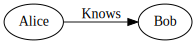

In [158]:
from neo4j.v1 import GraphDatabase
from graphviz import Digraph

dot = Digraph(format='svg')
dot.graph_attr['rankdir']='LR'
dot.graph_attr['size']="4,4"

sess = driver.session()
with sess.begin_transaction() as tx:
    results = tx.run("MATCH (n1:Person)-[r]->(n2) RETURN n1,r,n2")
    for result in results:
        dot.edge(result["n1"].properties["name"], result["n2"].properties["name"], label=result["r"].type)

dot